In [ ]:
from IPython.display import clear_output

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sushanthaluwai","key":"aed3e686f96751b89cf132ca8014723e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset


Dataset URL: https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset
License(s): other


In [ ]:
!unzip semantic-drone-dataset.zip -d /dataset-folder

Archive:  semantic-drone-dataset.zip
  inflating: /dataset-folder/RGB_color_image_masks/RGB_color_image_masks/000.png  
  inflating: /dataset-folder/RGB_color_image_masks/RGB_color_image_masks/001.png  
  inflating: /dataset-folder/RGB_color_image_masks/RGB_color_image_masks/002.png  
  inflating: /dataset-folder/RGB_color_image_masks/RGB_color_image_masks/003.png  
  inflating: /dataset-folder/RGB_color_image_masks/RGB_color_image_masks/004.png  
  inflating: /dataset-folder/RGB_color_image_masks/RGB_color_image_masks/005.png  
  inflating: /dataset-folder/RGB_color_image_masks/RGB_color_image_masks/006.png  
  inflating: /dataset-folder/RGB_color_image_masks/RGB_color_image_masks/008.png  
  inflating: /dataset-folder/RGB_color_image_masks/RGB_color_image_masks/011.png  
  inflating: /dataset-folder/RGB_color_image_masks/RGB_color_image_masks/013.png  
  inflating: /dataset-folder/RGB_color_image_masks/RGB_color_image_masks/014.png  
  inflating: /dataset-folder/RGB_color_image_masks

In [ ]:
!pip install monai
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
import os
import re
import cv2
import PIL
import torch

import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch import nn
from torch.optim import AdamW
from tqdm.notebook import tqdm
from collections import defaultdict
from IPython.display import Markdown as md
from monai.metrics import DiceMetric, MeanIoU
from pytorch_lightning.callbacks import Callback
from torchmetrics.classification import Accuracy
from monai.inferers import SlidingWindowSplitter
from torch.optim.lr_scheduler import PolynomialLR
from monai.inferers import AvgMerger, PatchInferer
from datetime import datetime, timedelta, timezone
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping



In [ ]:
pl.seed_everything(52)

INFO:lightning_fabric.utilities.seed:Seed set to 52


52

In [ ]:
def get_dir_files(dir: str):
    files = os.listdir(dir)
    files.sort(key=lambda x: int(re.search(r'\d+', x).group()))
    return [os.path.join(dir, f) for f in files]

DATASET = '/dataset-folder/'

IMAGE_DIR = os.path.join(DATASET, 'dataset/semantic_drone_dataset/original_images')
LABELS_DIR = os.path.join(DATASET, 'dataset/semantic_drone_dataset/label_images_semantic')
MASK_DIR = os.path.join(DATASET, 'RGB_color_image_masks/RGB_color_image_masks')

MASKS = get_dir_files(MASK_DIR)
LABELS = get_dir_files(LABELS_DIR)
IMAGES = get_dir_files(IMAGE_DIR)


LIMIT = 500  # Change this value if needed
IMAGES = IMAGES[:LIMIT]
LABELS = LABELS[:LIMIT]
MASKS = MASKS[:LIMIT]

CLASSES = pd.read_csv(os.path.join(DATASET, 'class_dict_seg.csv'))

TO_MASK_DICT = CLASSES.iloc[:, 1:].T.to_dict()
TO_MASK_DICT = {k: np.array(list(TO_MASK_DICT[k].values())) for k in TO_MASK_DICT}

In [ ]:
def to_mask(labels: torch.Tensor, to_mask_dict: dict) -> torch.Tensor:
    labels = labels.cpu().detach().numpy()
    height, width = labels.shape
    mask = np.zeros((height, width, 3), dtype=np.uint8)
    for k in to_mask_dict:
       mask[labels == k] = to_mask_dict[k]
    mask = torch.tensor(mask).permute(-1, 0, 1)
    return mask

In [ ]:
def display_md(text: str):
    display(md(text))

### **Data info**

Number of images: **400**

Number of labels: **24**

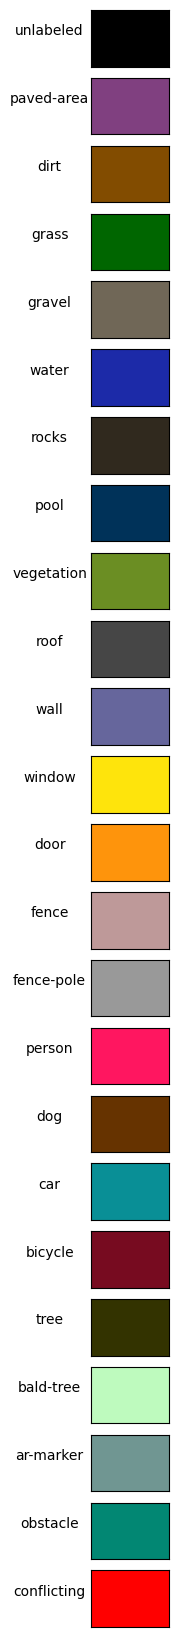

In [ ]:
display_md("### **Data info**")
display_md(f"Number of images: **{len(IMAGES)}**")
display_md(f"Number of labels: **{CLASSES.shape[0]}**")
fig, axes = plt.subplots(CLASSES.shape[0], 1, figsize=(1, 21))
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.set_facecolor(tuple(CLASSES.iloc[i, 1:].values / 255))
    ax.plot()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(CLASSES.iloc[i, 0], rotation=0, labelpad=30)
plt.show()

In [ ]:
def show_pil_images(filepaths: str | list,
                    figsize: tuple | None=None,
                    titles: tuple=(None, None, None)):
    if not isinstance(filepaths, list):
        filepaths = [filepaths]
    images = [
        np.array(PIL.Image.open(filepath).convert('RGB'))
        for filepath in filepaths
    ]
    fig, axes = plt.subplots(1, len(filepaths), figsize=figsize)
    if not isinstance(axes, np.ndarray):
        axes = [axes]
    for ax, image, title in zip(axes, images, titles):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.close()
    return fig

### **Dataset images**

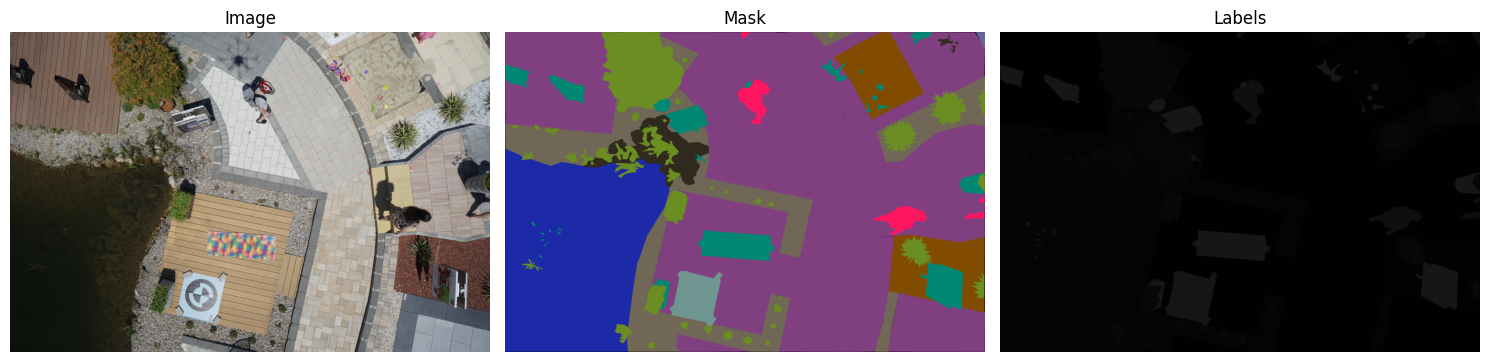

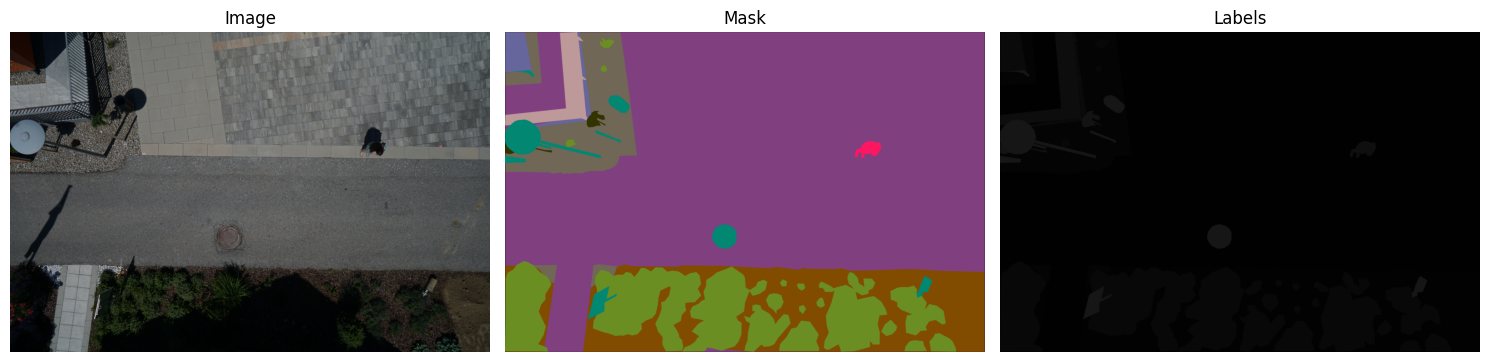

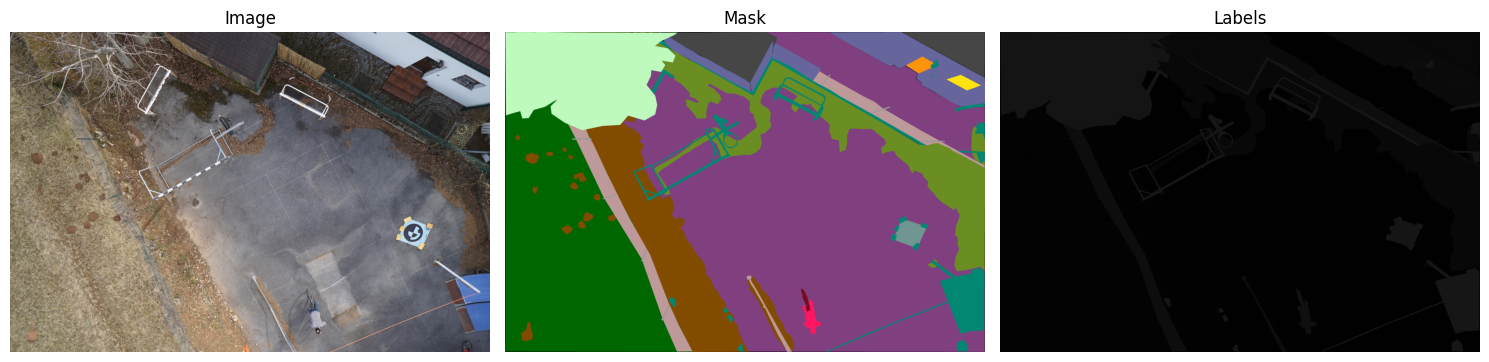

In [ ]:
display_md("### **Dataset images**")
idxs = np.random.randint(len(IMAGES), size=3)
for i in idxs:
    display(
        show_pil_images(
            filepaths=[IMAGES[i], MASKS[i], LABELS[i]],
            titles=('Image', 'Mask', 'Labels'),
            figsize=(15, 5))
    )

In [ ]:
classes_distr = defaultdict(list)

for filepath in tqdm(LABELS, leave=False):
    labels = np.array(PIL.Image.open(filepath).convert('L'))
    for label, name in CLASSES['name'].to_dict().items():
        classes_distr[name].append((labels == label).mean())

classes_distr = pd.DataFrame(classes_distr)


  0%|          | 0/400 [00:00<?, ?it/s]

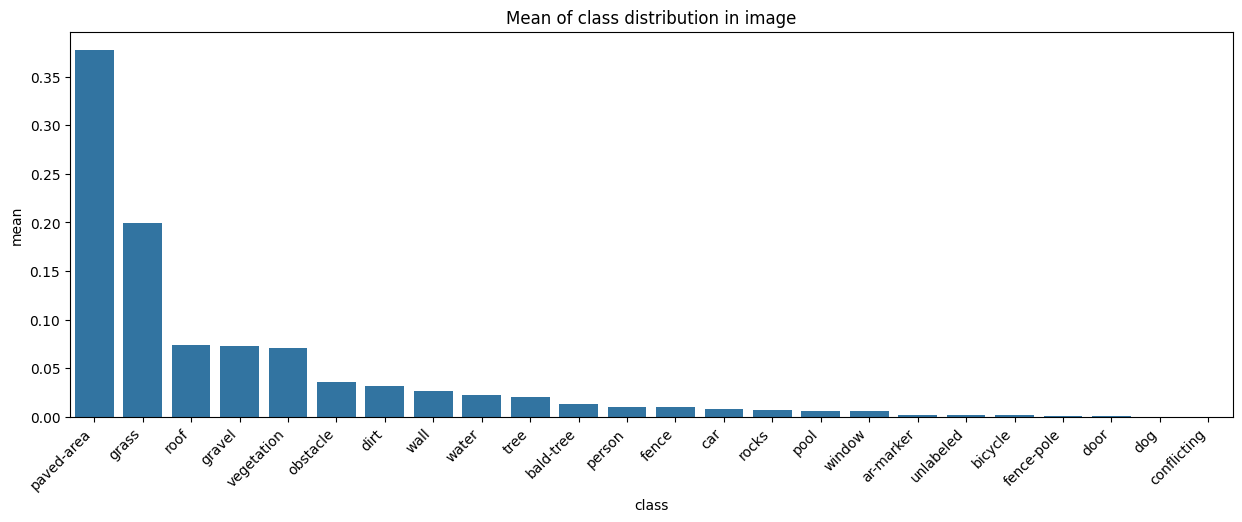

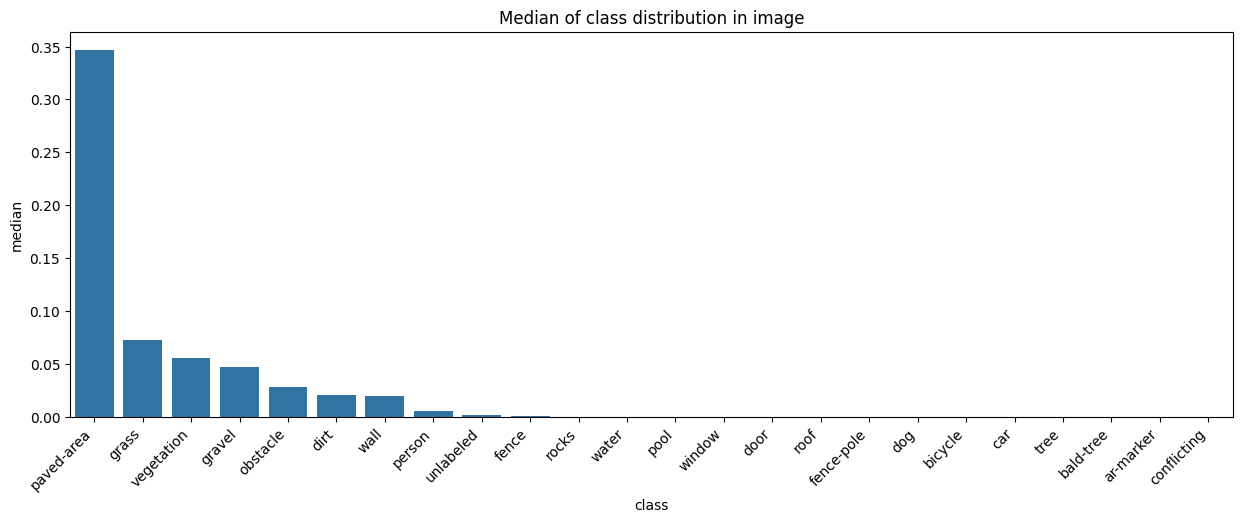

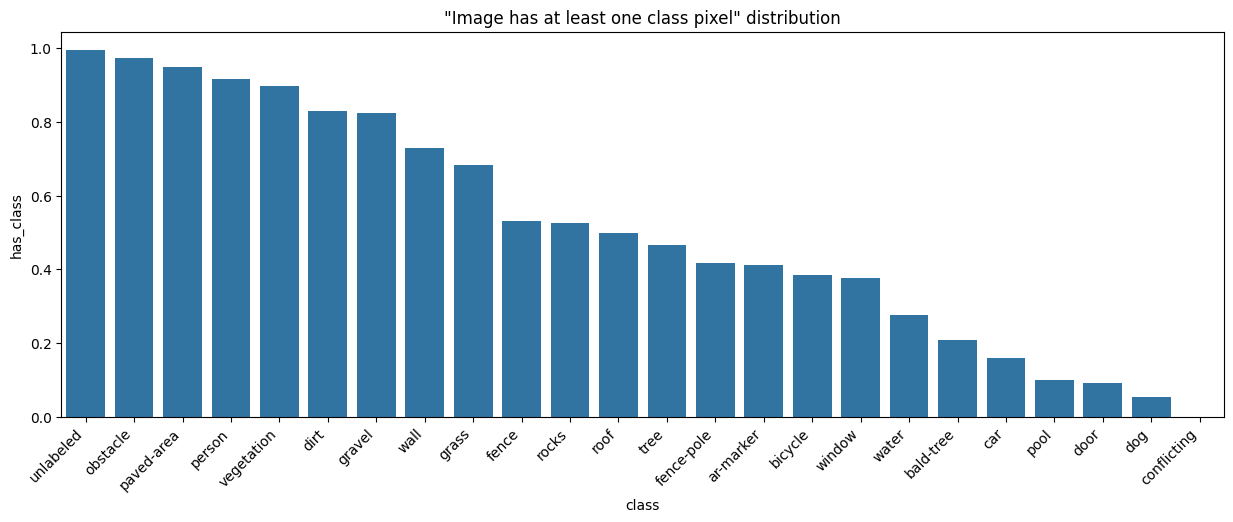

In [ ]:
stats = pd.DataFrame({
    'mean': classes_distr.mean(),
    'median': classes_distr.quantile(0.5),
    'has_class': (classes_distr > 0).mean()
}).reset_index().rename(columns={'index': 'class'})

fig = plt.figure(figsize=(15, 5))
sns.barplot(stats.sort_values(['mean'], ascending=False), x='class', y='mean')
plt.title('Mean of class distribution in image')
plt.xticks(rotation = 45, ha='right')
plt.show()

fig = plt.figure(figsize=(15, 5))
sns.barplot(stats.sort_values(['median'], ascending=False), x='class', y='median')
plt.title('Median of class distribution in image')
plt.xticks(rotation = 45, ha='right')
plt.show()

fig = plt.figure(figsize=(15, 5))
sns.barplot(stats.sort_values(['has_class'], ascending=False), x='class', y='has_class')
plt.title('"Image has at least one class pixel" distribution')
plt.xticks(rotation = 45, ha='right')
plt.show()

In [ ]:
class DroneDataset(Dataset):

    def __init__(self,
                 image_pths: list | np.ndarray,
                 labels_pths: list | np.ndarray | None=None,
                 transforms: A.Compose | None=None):
        self.image_pths = np.array(image_pths)
        self.labels_pths = labels_pths
        if labels_pths is not None:
            self.labels_pths = np.array(self.labels_pths)
        self.transforms = transforms


    def __len__(self):
        return self.image_pths.shape[0]

    def __getitem__(self, idx: int):
        image_pth = self.image_pths[idx]
        image = cv2.imread(image_pth)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.labels_pths is not None:
            label_path = self.labels_pths[idx]
            labels = cv2.imread(label_path)
            labels = cv2.cvtColor(labels, cv2.COLOR_BGR2GRAY)
        else:
            labels = None

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=labels)
            image = transformed['image']
            if self.labels_pths is not None:
                labels = transformed['mask']
        else:
            if self.labels_pths is not None:
                labels = torch.tensor(labels, dtype=torch.uint8)
            image = torch.tensor(image, dtype=torch.uint8).permute(-1, 0, 1)
        return image, labels


In [ ]:
class DroneDataModule(pl.LightningDataModule):

    def __init__(self,
                 image_pths: list | np.ndarray,
                 labels_pths: list | np.ndarray | None=None,
                 hf_model_name: str='nvidia/segformer-b1-finetuned-cityscapes-1024-1024',
                 batch_size: int=4,
                 train_indices: list | None=None,
                 train_frac: float | None=0.83,
                 num_workers: int=0):

        assert train_indices is None or train_frac is None, ""
        assert train_indices is not None or train_frac is not None, ""

        super().__init__()

        self.height, self.width = 1024, 1536
        super().save_hyperparameters()
        self.hparams.image_pths = np.array(self.hparams.image_pths)
        if self.hparams.labels_pths is not None:
            self.hparams.labels_pths = np.array(self.hparams.labels_pths)

        self.preprocessor = (
            SegformerImageProcessor
            .from_pretrained(hf_model_name,
                             do_reduce_labels=False)
        )
        h, w =  self.preprocessor.size.values()
        scale_val = (h * w) / (self.height * self.width)
        ratio_val = self.height / self.width
        self.train_transforms = A.Compose([
            A.Resize(self.height, self.width),
            A.RandomResizedCrop(size=(h, w),
                                scale=(scale_val, scale_val),
                                ratio=(ratio_val, ratio_val),
                                interpolation=cv2.INTER_AREA,
                                p=1),
            A.HorizontalFlip(p=0.5),
            A.ToTensorV2()
        ])
        self.inference_transforms = A.Compose([
            A.Resize(self.height, self.width),
            A.ToTensorV2()
        ])

    def setup(self, stage: str | None=None):
        if stage == 'fit':
            if self.hparams.train_frac and not self.hparams.train_indices:
                indices = np.arange(self.hparams.image_pths.shape[0])
                np.random.shuffle(indices)
                split_pct = int(self.hparams.train_frac * self.hparams.image_pths.shape[0])
                train_indices = np.sort(indices[:split_pct]).tolist()
                valid_indices = np.sort(indices[split_pct:]).tolist()
                train_image_pths = self.hparams.image_pths[train_indices]
                valid_image_pths = self.hparams.image_pths[valid_indices]
                train_labels_pths = self.hparams.labels_pths[train_indices]
                valid_labels_pths = self.hparams.labels_pths[valid_indices]
            elif not self.hparams.train_frac and self.hparams.train_indices:
                self.hparams.train_indices = sorted(self.hparams.train_indices)
                valid_indices = list(set(range(self.hparams.image_pths.shape[0]))
                                     - set(self.hparams.train_indices))
                valid_indices = sorted(valid_indices)
                train_image_pths = self.hparams.image_pths[self.hparams.train_indices]
                valid_image_pths = self.hparams.image_pths[valid_indices]
                train_labels_pths = self.hparams.labels_pths[self.hparams.train_indices]
                valid_labels_pths = self.hparams.labels_pths[valid_indices]

            self.train = DroneDataset(
                image_pths=train_image_pths,
                labels_pths=train_labels_pths,
                transforms=self.train_transforms
            )
            self.valid = DroneDataset(
                image_pths=valid_image_pths,
                labels_pths=valid_labels_pths,
                transforms=self.inference_transforms
            )

        elif stage == 'predict':
            self.dataset = DroneDataset(
                image_pths=self.hparams.image_pths,
                labels_pths=self.hparams.labels_pths,
                transforms=self.inference_transforms
            )

    def collate_fn(self, batch):
        images, labels = list(zip(*batch))
        preprocessed = self.preprocessor.preprocess(
            images=images,
            segmentation_maps=labels,
            return_tensors='pt'
        )
        if 'labels' not in preprocessed:
            preprocessed['labels'] = _
        return preprocessed['pixel_values'], preprocessed['labels']


    def train_dataloader(self):
        return DataLoader(self.train,
                          shuffle=True,
                          collate_fn=self.collate_fn,
                          batch_size=self.hparams.batch_size,
                          num_workers=self.hparams.num_workers)

    def val_dataloader(self):
        return DataLoader(self.valid,
                          shuffle=False,
                          batch_size=self.hparams.batch_size,
                          num_workers=self.hparams.num_workers)

    def predict_dataloader(self):
        return DataLoader(self.dataset,
                          shuffle=False,
                          batch_size=self.hparams.batch_size,
                          num_workers=self.hparams.num_workers)

In [ ]:
#X_train, X_val = train_test_split(classes_distr, train_size=332, random_state=55)
X_train, X_val = train_test_split(classes_distr, train_size=0.8, random_state=55)

pd.DataFrame({
    'train_distr': (X_train > 0).mean(),
    'val_distr': (X_val > 0).mean(),
    'train_distr': (X_train > 0).sum(),
    'val_distr': (X_val > 0).sum()
}).sort_values(['val_distr'])

train_distr  val_distr
conflicting            0          0
pool                  35          5
dog                   16          5
door                  30          7
car                   50         14
bald-tree             69         14
water                 92         19
ar-marker            141         24
fence-pole           138         29
window               122         29
tree                 154         32
roof                 166         33
fence                175         37
bicycle              114         40
rocks                168         42
grass                222         51
wall                 240         52
dirt                 268         64
gravel               262         68
vegetation           286         73
person               291         76
obstacle             313         76
paved-area           302         78
unlabeled            318         80

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


### **After augmentation**

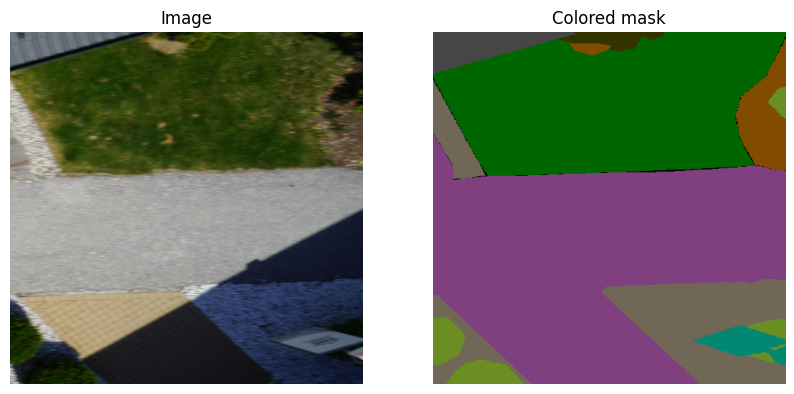

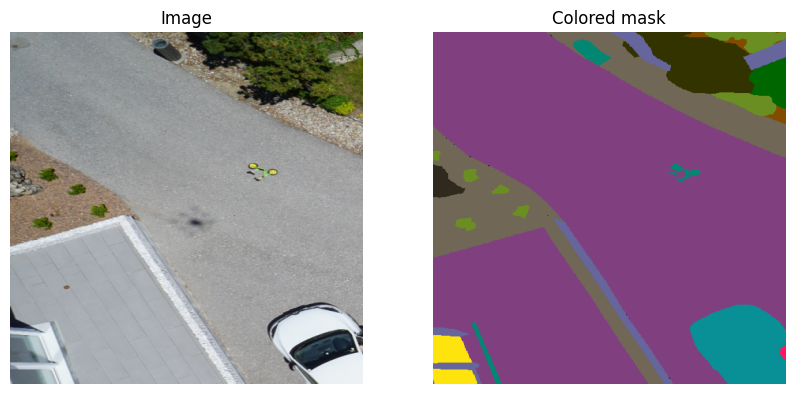

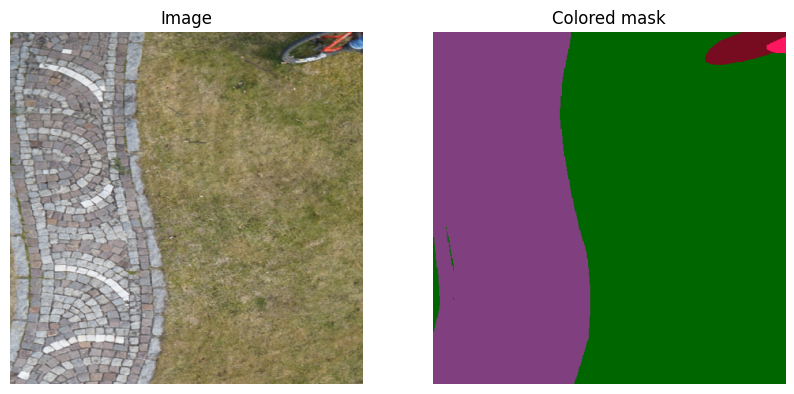

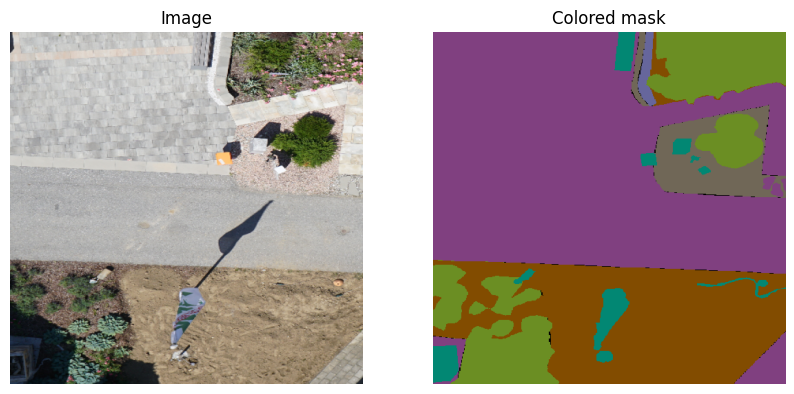

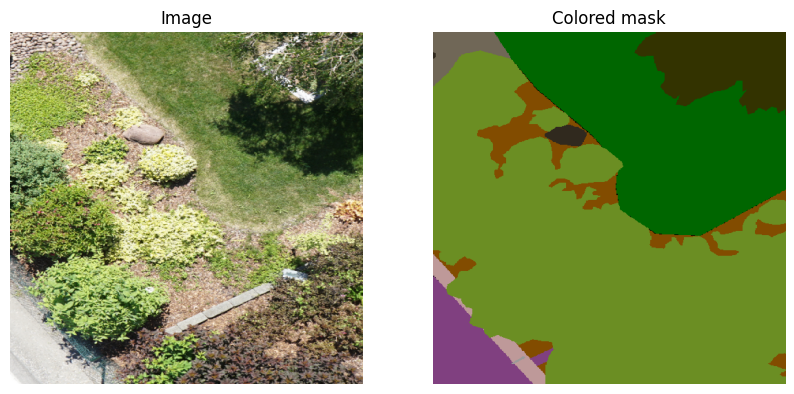

In [ ]:
datamodule_testing = DroneDataModule(
    image_pths=IMAGES,
    labels_pths=LABELS,
    batch_size=4,
    train_indices=list(X_train.sort_index().index),
    train_frac=None,
    num_workers=0,
    hf_model_name='nvidia/segformer-b0-finetuned-ade-512-512'
)

datamodule_testing.setup('fit')

display_md("### **After augmentation**")

for i in np.random.randint(len(datamodule_testing.train), size=5):
    image, labels = datamodule_testing.train[i]
    mask = to_mask(labels, TO_MASK_DICT)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(np.asarray(torchvision.transforms.ToPILImage()(image)))
    ax1.set_title("Image")
    ax1.axis('off')
    ax2.imshow(np.asarray(torchvision.transforms.ToPILImage()(mask)))
    ax2.set_title("Colored mask")
    ax2.axis('off')
    plt.show()

### **Patch inference**

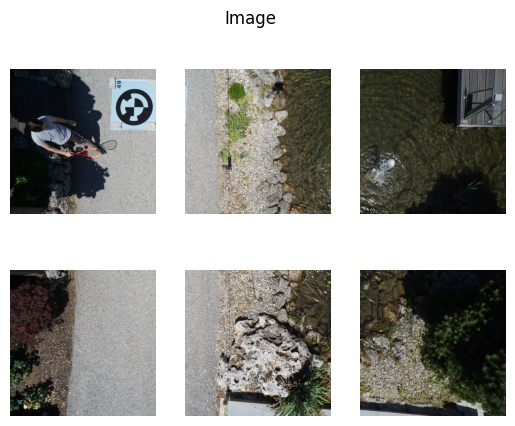

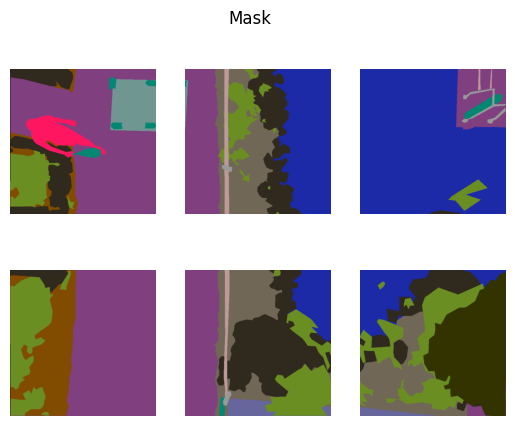

In [ ]:
display_md("### **Patch inference**")

for batch in datamodule_testing.val_dataloader():
    images, labels = batch
    break

image_h, image_w = datamodule_testing.height, datamodule_testing.width
model_h, model_w = datamodule_testing.preprocessor.size.values()
splitter = SlidingWindowSplitter(patch_size=(model_h, model_w), overlap=0)
h, w = splitter.patch_size

fig, axes = plt.subplots(image_h // model_h + (image_h % model_h != 0),
                         image_w // model_w + (image_w % model_w != 0))
if axes.ndim == 1:
    axes = np.array([axes])
for image_patches in splitter(images[1].unsqueeze(0)):
    np_image_patches = image_patches[0][0].permute(1, 2, 0).cpu().detach().numpy()
    i, j = image_patches[1]
    i = i // h
    j = j // w
    axes[i, j].imshow(np_image_patches)
    axes[i, j].axis('off')
plt.suptitle('Image')
plt.show()

fig, axes = plt.subplots(image_h // model_h + (image_h % model_h != 0),
                         image_w // model_w + (image_w % model_w != 0))
if axes.ndim == 1:
    axes = np.array([axes])
for label_patches in splitter(labels[1].unsqueeze(0).unsqueeze(0)):
    np_mask_patches = to_mask(label_patches[0].squeeze(0).squeeze(0), TO_MASK_DICT).permute(1, 2, 0).cpu().detach().numpy()
    i, j = label_patches[1]
    i = i // h
    j = j // w
    axes[i, j].imshow(np_mask_patches)
    axes[i, j].axis('off')
plt.suptitle('Mask')
plt.show()

In [ ]:
del datamodule_testing

In [ ]:
# is_login = wandb.login(key=UserSecretsClient().get_secret('wndb_api_key'))
# clear_output()
# display_md(f"Successful login: {is_login}")

In [ ]:
class DroneModel(pl.LightningModule):

    def __init__(self,
                 id2label: dict,
                 lr: float=6e-05,
                 hf_model_name: str='nvidia/segformer-b1-finetuned-cityscapes-1024-1024'):

        super().__init__()
        super().save_hyperparameters()
        label2id = { v: k for k, v in id2label.items() }
        self.segformer = (
            SegformerForSemanticSegmentation
            .from_pretrained(
                hf_model_name,
                num_labels=len(id2label),
                id2label=id2label,
                label2id=label2id,
                ignore_mismatched_sizes=True,
                semantic_loss_ignore_index=0
            )
        )

    def get_inferer(self):
        model_height, model_width = self.trainer.datamodule.preprocessor.size.values()
        splitter = SlidingWindowSplitter(patch_size=(model_height, model_width), overlap=0.25)

        def preprocessing(patches):
            return (
                self.trainer.datamodule
                .preprocessor(patches, return_tensors='pt')['pixel_values']
                .to(self.device)
            )

        def postprocessing(outputs):
            upsample = nn.Upsample(size=(model_height, model_width), mode='bilinear')
            return F.softmax(upsample(outputs['logits']), dim=1)

        return PatchInferer(
            splitter=splitter,
            merger_cls=AvgMerger,
            preprocessing=preprocessing,
            postprocessing=postprocessing,
            device=self.device
        )

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = PolynomialLR(optimizer, total_iters=self.trainer.max_epochs, power=1.0)
        return { 'optimizer': optimizer, 'lr_scheduler': scheduler }

    def on_fit_start(self):
        self.inferer = self.get_inferer()

    def training_step(self, batch, batch_idx):
        images, masks = batch
        batch_size = images.size(0)
        train_loss = self.segformer(images, masks).loss
        self.log('train_loss', train_loss.item(), on_step=True,
                 on_epoch=True, batch_size=batch_size)
        return train_loss

    def on_validation_epoch_start(self):
        num_classes = len(self.hparams.id2label)
        self.dice_metric = DiceMetric(num_classes=num_classes,
                                      include_background=False,
                                      reduction='mean_batch')
        self.iou_metric = MeanIoU(include_background=False,
                                  reduction='mean_batch')
        self.accuracy_metric = Accuracy(num_classes=num_classes,
                                        ignore_index=0,
                                        task='multiclass',
                                        multidim_average='global').to(self.device)

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        batch_size = images.size(0)
        with torch.no_grad():
            probas = self.inferer(inputs=images, network=self.segformer)
        preds = torch.argmax(probas, dim=1)

        log_probas = torch.log(probas)
        valid_loss = F.nll_loss(log_probas, labels.to(torch.long), reduction='mean', ignore_index=0)
        self.log('valid_loss', valid_loss.item(), on_step=True,
                 on_epoch=True, batch_size=batch_size)

        num_classes = len(self.hparams.id2label)
        one_hot_preds = F.one_hot(preds, num_classes=num_classes).permute(0, -1, 1, 2)
        one_hot_labels = F.one_hot(labels.to(torch.long), num_classes=num_classes).permute(0, -1, 1, 2)

        accuracy = self.accuracy_metric(labels, preds)
        self.log('accuracy', accuracy.item(), on_step=True,
                 on_epoch=True, batch_size=batch_size)

        self.dice_metric.reset()
        self.dice_metric(one_hot_preds, one_hot_labels)
        agg_dice = self.dice_metric.aggregate()
        dice = { f"{self.hparams.id2label[i]}_dice": agg_dice[i - 1].item()
                 for i in self.hparams.id2label if i != 0 }
        self.log_dict(dice, on_step=True, on_epoch=True, batch_size=batch_size)
        self.log('mean_dice', agg_dice.mean().item(), on_step=True,
                 on_epoch=True, batch_size=batch_size)

        self.iou_metric.reset()
        self.iou_metric(one_hot_preds, one_hot_labels)
        agg_iou = self.iou_metric.aggregate()
        iou = { f"{self.hparams.id2label[i]}_iou": agg_iou[i - 1].item()
                for i in self.hparams.id2label if i != 0 }
        self.log_dict(iou, on_step=True, on_epoch=True, batch_size=batch_size)
        self.log('mean_iou', agg_iou.mean().item(), on_step=True,
                 on_epoch=True, batch_size=batch_size)

    def on_save_checkpoint(self, checkpoint):
        metrics = self.trainer.callback_metrics
        for m in ['loss', 'iou', 'dice']:
            checkpoint[m] = { k: metrics[k] for k in metrics if m in k }
        if 'accuracy' in metrics:
            checkpoint['accuracy'] = metrics['accuracy'].item()

    def on_predict_start(self):
        self.inferer = self.get_inferer()

    def predict_step(self, batch, batch_idx):
        images, labels = batch
        with torch.no_grad():
            probas = self.inferer(inputs=images, network=self.segformer)
        preds = torch.argmax(probas, dim=1).to(torch.uint8)
        return [pred for pred in preds]

In [ ]:
HF_MODEL_NAME = 'nvidia/segformer-b0-finetuned-ade-512-512'

datamodule = DroneDataModule(
    image_pths=IMAGES,
    labels_pths=LABELS,
    batch_size=1,
    train_indices=list(X_train.sort_index().index),
    train_frac=None,
    num_workers=0,
    hf_model_name=HF_MODEL_NAME
)

ID2LABEL = CLASSES.name.to_dict()

model = DroneModel(id2label=ID2LABEL,
                   hf_model_name=HF_MODEL_NAME)

config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([24]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([24, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger

utc_now = datetime.now(timezone.utc)
utc_plus_3 = utc_now + timedelta(hours=3)
timestamp = utc_plus_3.strftime("%Y-%m-%d %H:%M:%S")
print(f"Training started at {timestamp}")

# Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath='./best_models',
    filename='drone_segformer-{epoch:02d}-{valid_loss:.2f}',
    monitor='valid_loss',
    save_top_k=3
)

early_stop_callback = EarlyStopping(
    monitor='valid_loss',
    patience=12,
    verbose=True,
    mode='min'
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

# Initialize the TensorBoard logger
logger = TensorBoardLogger("tb_logs", name="segformer")

# Trainer with TensorBoard logger
trainer = pl.Trainer(
    log_every_n_steps=1,
    accelerator='gpu',
    devices='auto',
    max_time="00:10:00:00",
    max_epochs=40,
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    logger=logger  # Add logger here
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training started at 2025-04-27 09:56:26


In [ ]:
try:
    trainer.fit(model, datamodule)
    clear_output()
except KeyboardInterrupt:
    print('Interrupted')
except NameError:
    print('Interrupted')

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                             | Params | Mode
----------------------------------------------------------------------
0 | segformer | SegformerForSemanticSegmentation | 3.7 M  | eval
----------------------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.881    Total estimated model params size (MB)
0         Modules in train mode
213       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved. New best score: 0.902


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.265 >= min_delta = 0.0. New best score: 0.637


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.071 >= min_delta = 0.0. New best score: 0.565


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.540


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.076 >= min_delta = 0.0. New best score: 0.464


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.429


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.408


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.375


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.351


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.347


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.337


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.320


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.310


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.305


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.291


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.289


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.279


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


Interrupted


In [ ]:
def extract_loss(filename):
    return float(filename.split('valid_loss=')[1].split('.ckpt')[0])

best_models = os.listdir('./best_models')
best_model_fpath = os.path.join('./best_models',
                                sorted(best_models, key=extract_loss)[0])

best_checkpoint = torch.load(best_model_fpath, weights_only=False)
best_model = DroneModel.load_from_checkpoint(best_model_fpath)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([24]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([24, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
results = dict()

results = {
    m: pd.Series({ k.replace(f"_{m}", ''): v.item() for k, v in best_checkpoint[m].items() if '_step' not in k and '_epoch' not in k}).sort_values().round(3)
    for m in ['loss', 'iou', 'dice']
}

for m in ['loss', 'iou', 'dice']:
    results[m] = pd.DataFrame(results[m], columns=[m])

for m in ['iou', 'dice']:
    results[m] = results[m].drop('mean')

In [ ]:
display_md(f"**Mean accuracy: {best_checkpoint['accuracy']:.3f}**")
display_md(f"**Mean IoU: {best_checkpoint['iou']['mean_iou']:.3f}**")
display_md(f"**Mean Dice: {best_checkpoint['dice']['mean_dice']:.3f}**")
print()
display(results['loss'])
print()
display(results['dice'].join(results['iou']).sort_values(['dice'], ascending=False))

NameError: name 'display_md' is not defined

In [ ]:
datamodule_test = DroneDataModule(
    image_pths=datamodule.valid.image_pths,
    labels_pths=datamodule.valid.labels_pths,
    batch_size=2,
    num_workers=0,
    hf_model_name=HF_MODEL_NAME
)
datamodule_test.setup('predict')

try:
    pred_labels = trainer.predict(best_model, datamodule_test)
    pred_labels = sum(pred_labels, [])
except KeyboardInterrupt:
    print('Interrupted')
except NameError:
    print('Interrupted')

for i, pred_label in enumerate(pred_labels):
    image, labels = datamodule_test.dataset[i]
    mask = to_mask(labels, TO_MASK_DICT)
    pred_mask = to_mask(pred_label, TO_MASK_DICT)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(np.asarray(torchvision.transforms.ToPILImage()(image)))
    ax1.set_title("Image")
    ax1.axis('off')
    ax2.imshow(np.asarray(torchvision.transforms.ToPILImage()(mask)))
    ax2.set_title("Ground true mask")
    ax2.axis('off')
    ax3.imshow(np.asarray(torchvision.transforms.ToPILImage()(pred_mask)))
    ax3.set_title("Predicted mask")
    ax3.axis('off')
    plt.show()

NameError: name 'DroneDataModule' is not defined